# Prosper Investments Loan Chargeoff Modeling

## Problem Statement

What opportunities exist as an individual investor to achieve a total portfolio return of at least 6.5% within the next 3 years by identifying high quality loan listings that maximizes interest yield but minimizes principal charge off loss exposure?

## Context

Prosper is a peer-to-peer lending marketplace that was founded in 2005 and has facilitated more than \\$18 billion in loans to more than 1 million people in the United States.  Borrowers apply online for personal loans ranging between \\$2,000 and \\$40,000 and individuals can invest in these loans.

Personal loans are unsecured notes since they are not collateralized by property such as an automobile or real estate.  These loans typically have higher interest rates to account for the higher risk of borrower default.  Prosper investments have historically yielded return of 5.3% so they can offer a way for individuals to diversify their portfolio beyond traditional investments.

The goal is to identify the highest quality loans to invest in to maximum rate of return.  The borrower can either:

1) Pay off the entire principal of the loan or<br>
2) Default on their loan and some percentage of the original principal loan amount charges off.  

We are most concerned with False negatives (FN), Type II errors, since this is the situation when the true status of the loan is `chargeoff` but the model predicted the full principal amount will be be `paid off`.  FN prediction errors increase the loss exposure in the pool of potential investments.

False positives (FP), Type I errors, is not as much of a concern since there is a finite amount of capital available for investing.  We will exclude all predicted `chargeoff` loans from the pool of potential investments but FP errors do represent, to some degree, opportunity cost for potential higher yield investments.

# 3 Preprocessing<a id='3_preprocessing'></a>

In [1]:
# Import libraries
import itertools
from time import time
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings for clean output in notebook
import warnings
warnings.filterwarnings('ignore')

## 3.1 Load Data

In [2]:
# Data directory references
intermediate_dir = r'..\data\intermediate'

In [3]:
# Load dtypes from df_clean from data wrangling step
dtypes_fn = 'clean_dtypes.json'
with open(os.path.join(intermediate_dir, dtypes_fn)) as f:
          clean_dtypes = json.load(f)
# Some models cannot handle Int16 data types
clean_dtypes['prosper_score'] = 'int32'
clean_dtypes['income_range'] = 'int32'

In [4]:
clean_fn = 'listings_clean.csv'
# Pass datetime fields to parse_dates
dtype = {k: v for k, v in clean_dtypes.items() if v != 'datetime64[ns]'}
parse_dates = [k for k, v in clean_dtypes.items() if v == 'datetime64[ns]']
df_clean = pd.read_csv(os.path.join(intermediate_dir, clean_fn), dtype=dtype, parse_dates=parse_dates)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579634 entries, 0 to 579633
Data columns (total 71 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   listing_number                                    579634 non-null  int64         
 1   origination_month                                 579634 non-null  float32       
 2   chargeoff_amount                                  579634 non-null  float32       
 3   debt_sale_recovery                                579634 non-null  float32       
 4   principal_paid                                    579634 non-null  float32       
 5   interest_paid                                     579634 non-null  float32       
 6   chargeoff                                         579634 non-null  int8          
 7   closed_month                                      579634 non-null  float32       
 8   listing_creati

In [5]:
df_clean.describe()

,listing_number,origination_month,chargeoff_amount,debt_sale_recovery,principal_paid,interest_paid,chargeoff,closed_month,listing_status,listing_amount,...,IN01S,IN09S,IN21S,MT01S,OF01S,RE01S,RE21S,RT01S,S207S,dti_wprosper_loan
count,5.796340e+05,579634.000000,579634.000000,579634.000000,579634.000000,579634.000000,579634.00000,579634.00000,579634.0,579634.000000,...,579634.000000,579634.000000,579634.000000,579634.000000,579634.000000,579634.000000,579634.000000,579634.000000,579634.000000,579634.000000
mean,6.262138e+06,201683.750000,1691.917725,167.806305,11700.482422,2737.887451,0.18536,201900.40625,6.0,13379.106445,...,7.283216,1.523641,20.731136,1.412691,1.492154,13.605087,13.210032,5.201783,3.714865,0.261039
std,2.295038e+06,137.205292,4561.408203,510.223389,8311.404297,2547.056885,0.38859,81.94915,0.0,8099.694824,...,6.726820,1.659852,27.767914,1.683995,2.742183,8.163167,30.788761,4.533339,25.884546,0.117930
min,6.935680e+05,201302.000000,0.000000,0.000000,0.000000,0.000000,0.00000,201801.00000,6.0,2000.000000,...,-4.000000,-5.000000,-5.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,0.000000
25%,4.459776e+06,201601.000000,0.000000,0.000000,5000.000000,975.349976,0.00000,201809.00000,6.0,7500.000000,...,3.000000,0.000000,6.000000,0.000000,0.000000,8.000000,4.000000,2.000000,-4.000000,0.170000
50%,6.347226e+06,201706.000000,0.000000,0.000000,10000.000000,1942.775024,0.00000,201905.00000,6.0,12000.000000,...,6.000000,1.000000,12.000000,1.000000,0.000000,12.000000,8.000000,4.000000,-4.000000,0.250000
75%,7.896140e+06,201803.000000,0.000000,0.000000,15000.000000,3677.442444,0.00000,202003.00000,6.0,18000.000000,...,10.000000,2.000000,23.000000,2.000000,2.000000,18.000000,16.000000,7.000000,-4.000000,0.330000
max,1.186894e+07,202012.000000,40000.000000,8359.160156,40000.000000,22950.960938,1.00000,202012.00000,6.0,40000.000000,...,281.000000,50.000000,528.000000,71.000000,118.000000,150.000000,9999.000000,85.000000,999.000000,0.860000


In [6]:
# Remove all loans closed prior to March 2020 as identified in EDA
df_clean = df_clean[df_clean['closed_month'] < 202003]
df_clean.describe()

,listing_number,origination_month,chargeoff_amount,debt_sale_recovery,principal_paid,interest_paid,chargeoff,closed_month,listing_status,listing_amount,...,IN01S,IN09S,IN21S,MT01S,OF01S,RE01S,RE21S,RT01S,S207S,dti_wprosper_loan
count,4.325510e+05,432551.000000,432551.000000,432551.000000,432551.00000,432551.000000,432551.000000,432551.000000,432551.0,432551.000000,...,432551.000000,432551.000000,432551.000000,432551.000000,432551.000000,432551.000000,432551.000000,432551.000000,432551.000000,432551.000000
mean,5.760034e+06,201654.531250,1854.869873,186.808975,11535.62500,2620.359131,0.201856,201864.031250,6.0,13366.694336,...,7.113645,1.505249,21.232773,1.400318,1.496325,13.845487,13.016334,5.159584,3.164811,0.263984
std,2.135328e+06,128.384445,4739.128418,533.104309,8279.59668,2425.640381,0.401386,61.580696,0.0,8041.244629,...,6.556548,1.645911,28.675198,1.664719,2.741379,8.177282,34.246483,4.468955,24.666348,0.118422
min,6.935680e+05,201302.000000,0.000000,0.000000,0.00000,0.000000,0.000000,201801.000000,6.0,2000.000000,...,-4.000000,-5.000000,-5.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,0.000000
25%,4.115003e+06,201512.000000,0.000000,0.000000,5000.00000,938.445007,0.000000,201807.000000,6.0,7500.000000,...,3.000000,0.000000,6.000000,0.000000,0.000000,8.000000,4.000000,2.000000,-4.000000,0.170000
50%,5.801216e+06,201702.000000,0.000000,0.000000,10000.00000,1865.560059,0.000000,201901.000000,6.0,12000.000000,...,5.000000,1.000000,12.000000,1.000000,0.000000,12.000000,8.000000,4.000000,-4.000000,0.250000
75%,7.356352e+06,201712.000000,0.000000,0.000000,15000.00000,3526.964966,0.000000,201907.000000,6.0,18000.000000,...,9.000000,2.000000,24.000000,2.000000,2.000000,18.000000,16.000000,7.000000,-4.000000,0.340000
max,1.113610e+07,202002.000000,40000.000000,8359.160156,40000.00000,21686.869141,1.000000,202002.000000,6.0,40000.000000,...,138.000000,50.000000,528.000000,49.000000,118.000000,128.000000,9999.000000,85.000000,124.000000,0.860000


In [7]:
# Drop columns identified in EDA stage as well as additional columns included for scenario analysis
df = df_clean.drop(['listing_number', 'origination_month', 'chargeoff_amount', 
                    'debt_sale_recovery', 'principal_paid', 'interest_paid',
                    'closed_month', 'listing_creation_date', 'loan_origination_date', 
                    'listing_status', 'lender_yield', 'borrower_apr', 'listing_monthly_payment', 'stated_monthly_income',
                    'income_verifiable', 'months_employed',
                    'prior_prosper_loans_active', 'prior_prosper_loans', 'prior_prosper_loans_principal_borrowed',
                    'prior_prosper_loans_principal_outstanding', 'prior_prosper_loans_balance_outstanding',
                    'prior_prosper_loans_cycles_billed', 'prior_prosper_loans_ontime_payments',
                    'prior_prosper_loans_late_cycles', 'prior_prosper_loans_late_payments_one_month_plus',
                    'max_prior_prosper_loan', 'min_prior_prosper_loan', 'prior_prosper_loan_earliest_pay_off', 
                    'prior_prosper_loans31dpd', 'prior_prosper_loans61dpd', 
                    'AT01S', 'G041S', 'G042S', 'G043S', 'G058S','G059S','G061S', 'G063S', 'G064S', 'G066S', 'G068S', 
                    'G069S','G071S', 'IN01S', 'MT01S', 'RE01S',
                    'lender_indicator', 'co_borrower_application'
                   ], errors='ignore', axis=1)


df.head()

,chargeoff,listing_amount,prosper_rating,borrower_rate,listing_term,prosper_score,income_range,employment_status_description,occupation,borrower_state,...,G093S,G103S,HI01S,IN09S,IN21S,OF01S,RE21S,RT01S,S207S,dti_wprosper_loan
0,1,2000.0,C,0.1970,60,4,4,Employed,Nurse's Aide,OR,...,1.0,12.0,0.0,1.0,15.0,0.0,12.0,6.0,-4.0,0.18
1,1,7000.0,C,0.1970,60,5,4,Employed,Sales - Retail,CA,...,0.0,9.0,0.0,0.0,44.0,0.0,9.0,5.0,-4.0,0.46
2,1,32000.0,B,0.1440,60,11,6,Employed,Food Service Management,PA,...,0.0,8.0,0.0,1.0,24.0,0.0,13.0,4.0,-4.0,0.14
3,1,12000.0,C,0.1980,60,4,4,Employed,Other,NJ,...,2.0,2.0,0.0,2.0,13.0,11.0,2.0,12.0,-4.0,0.26
4,1,15000.0,C,0.2024,60,3,6,Employed,Attorney,AK,...,0.0,12.0,2.0,0.0,25.0,14.0,27.0,1.0,-4.0,0.25


## 3.2 Transform Data

### 3.2.1 Clean Columns

In [8]:
# Review counts of employment_status_description before
df['employment_status_description'].value_counts()

Employed         370056
Self-employed     31217
Other             30674
Full-time           574
Retired              13
Part-time            11
Not employed          6
Name: employment_status_description, dtype: int64

In [9]:
# Clean employment_status_description field
emp_dict = {'Full-time': 'Employed', 'Retired': 'Other', 'Not employed': 'Other', 'Part-time': 'Other'}
df['employment_type'] = df['employment_status_description'].map(emp_dict).fillna(df['employment_status_description'])
df['employment_type'].value_counts()

Employed         370630
Self-employed     31217
Other             30704
Name: employment_type, dtype: int64

### 3.2.2 One-Hot Encoding

In [10]:
# Categorical columns that will utilize unsupervised one-hot encoding
dummy_cols = ['prosper_score', 'income_range', 'prosper_rating', 'listing_term', 'employment_type']

df_transformed = pd.get_dummies(data=df, columns=dummy_cols, drop_first=True)

# Drop employment_status_description columns
df_transformed = df_transformed.drop(['employment_status_description'], axis=1, errors='ignore')

df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432551 entries, 0 to 575938
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   chargeoff                      432551 non-null  int8   
 1   listing_amount                 432551 non-null  float32
 2   borrower_rate                  432551 non-null  float32
 3   occupation                     432551 non-null  object 
 4   borrower_state                 432551 non-null  object 
 5   AT02S                          432551 non-null  float32
 6   AU01S                          432551 non-null  float32
 7   G020S                          432551 non-null  float32
 8   G093S                          432551 non-null  float32
 9   G103S                          432551 non-null  float32
 10  HI01S                          432551 non-null  float32
 11  IN09S                          432551 non-null  float32
 12  IN21S                         

### 3.2.3 Supervised Categorical Encoding

In [11]:
# Split data for train and test sets
SEED = 42

from sklearn.model_selection import train_test_split
X = df_transformed.drop(['chargeoff'], axis=1)
y = df_transformed['chargeoff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)

X_train.head()

,listing_amount,borrower_rate,occupation,borrower_state,AT02S,AU01S,G020S,G093S,G103S,HI01S,...,income_range_6,prosper_rating_AA,prosper_rating_B,prosper_rating_C,prosper_rating_D,prosper_rating_E,prosper_rating_HR,listing_term_60,employment_type_Other,employment_type_Self-employed
313456,20000.0,0.1479,Other,TX,14.0,4.0,16.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,1,0
218861,7500.0,0.0600,Other,CA,14.0,3.0,0.0,0.0,13.0,0.0,...,0,1,0,0,0,0,0,0,0,0
285445,10000.0,0.0870,Unknown,TX,16.0,2.0,25.0,0.0,5.0,1.0,...,0,0,0,0,0,0,0,0,1,0
113452,12000.0,0.1601,Other,WA,11.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,1,0,0,0,0,0,0
233219,18000.0,0.1030,Clerical,AZ,14.0,2.0,14.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,1,0,0


In [12]:
from feature_engine.encoding import WoEEncoder, RareLabelEncoder

woe_cols = ['occupation', 'borrower_state']

# Set up a rare label encoder
rare_encoder = RareLabelEncoder(tol=0.01, variables=woe_cols, replace_with='Other')

# fit and transform data
X_train = rare_encoder.fit_transform(X_train)
X_test = rare_encoder.transform(X_test)

# Set up a weight of evidence encoder
woe_encoder = WoEEncoder(variables=woe_cols)

# fit the encoder
woe_encoder.fit(X_train, y_train)

# transform
X_train = woe_encoder.transform(X_train)
X_test = woe_encoder.transform(X_test)

X_train.head()

,listing_amount,borrower_rate,occupation,borrower_state,AT02S,AU01S,G020S,G093S,G103S,HI01S,...,income_range_6,prosper_rating_AA,prosper_rating_B,prosper_rating_C,prosper_rating_D,prosper_rating_E,prosper_rating_HR,listing_term_60,employment_type_Other,employment_type_Self-employed
313456,20000.0,0.1479,-0.001972,0.042682,14.0,4.0,16.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,1,0
218861,7500.0,0.0600,-0.001972,0.039821,14.0,3.0,0.0,0.0,13.0,0.0,...,0,1,0,0,0,0,0,0,0,0
285445,10000.0,0.0870,0.275318,0.042682,16.0,2.0,25.0,0.0,5.0,1.0,...,0,0,0,0,0,0,0,0,1,0
113452,12000.0,0.1601,-0.001972,-0.357111,11.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,1,0,0,0,0,0,0
233219,18000.0,0.1030,-0.016928,0.069210,14.0,2.0,14.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,1,0,0


### 3.2.4 Supervised Numerical Scaling

In [13]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#scaler = MinMaxScaler()
scaler = StandardScaler()

ss_cols = ['listing_amount', 'borrower_rate', 
           'AT02S','AU01S','G020S','G093S','G103S','HI01S','IN09S','IN21S','OF01S','RE21S', 'RT01S','S207S',
          'dti_wprosper_loan']

scaler.fit(X_train[ss_cols])

X_train[ss_cols] = scaler.transform(X_train[ss_cols])
X_test[ss_cols] = scaler.transform(X_test[ss_cols])

X_train.head()

,listing_amount,borrower_rate,occupation,borrower_state,AT02S,AU01S,G020S,G093S,G103S,HI01S,...,income_range_6,prosper_rating_AA,prosper_rating_B,prosper_rating_C,prosper_rating_D,prosper_rating_E,prosper_rating_HR,listing_term_60,employment_type_Other,employment_type_Self-employed
313456,0.824612,-0.087098,-0.001972,0.042682,0.486212,0.450316,0.812017,-0.366358,-0.982943,-0.281587,...,0,0,0,1,0,0,0,1,1,0
218861,-0.729622,-1.358911,-0.001972,0.039821,0.486212,0.064387,-0.852606,-0.366358,1.149470,-0.281587,...,0,1,0,0,0,0,0,0,0,0
285445,-0.418775,-0.968251,0.275318,0.042682,0.836055,-0.321541,1.748368,-0.366358,-0.162784,2.348040,...,0,0,0,0,0,0,0,0,1,0
113452,-0.170097,0.089422,-0.001972,-0.357111,-0.038552,-1.093397,-0.852606,-0.366358,-0.490847,-0.281587,...,0,0,0,1,0,0,0,0,0,0
233219,0.575935,-0.736750,-0.016928,0.069210,0.486212,-0.321541,0.603939,-0.366358,-0.818911,-0.281587,...,0,0,1,0,0,0,0,1,0,0


# 4 Modeling<a id='4_modeling'></a>

### 4.1 Helper Functions

In [14]:
# Import metrics
from sklearn import metrics

# Capture various model evaluation metrics
def model_metrics(model, X, y):
    results = {}
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    results['Predictions'] = y_pred
    results['Probabilities'] = y_pred_prob
    results['Accuracy Score'] = metrics.accuracy_score(y, y_pred)
    results['Precision Score'] = metrics.precision_score(y, y_pred, zero_division=0)
    results['Recall Score'] = metrics.recall_score(y, y_pred, zero_division=0)
    results['F1 Score'] = metrics.f1_score(y, y_pred)
    results['F2 Score'] = metrics.fbeta_score(y, y_pred, beta=2)
    results['Average Precision Score'] = metrics.average_precision_score(y, y_pred_prob)
    results['False Omission Rate'] = fn / (fn + tn)
    return results

In [15]:
# Evaluate model and track training time
def evaluate_model(desc, clf, X, y):
    data = {}
    data['Model Description'] = desc
    data['Classifier'] = clf
    start = time()
    model = clf.fit(X, y)
    end = time()
    data['Training Time'] = end - start
    train_results = model_metrics(model, X, y)
    data['Train Results'] = train_results
    test_results = model_metrics(model, X_test, y_test)
    data['Test Results'] = test_results
    return data

In [16]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    np.set_printoptions(precision=2)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### 4.2 Baseline Dummy Classifier

In [17]:
def plot_roc_curve(y_test, probs):
    # Calculate fpr, tpr, thresholds and roc_auc
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

Train a baseline dummy classifier that predicts the most frequent class or `paidoff`.

In [18]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_results = evaluate_model('Dummy Classifier', dummy_clf, X_train, y_train)

dummy_results

{'Model Description': 'Dummy Classifier',
 'Classifier': DummyClassifier(strategy='most_frequent'),
 'Training Time': 0.014960527420043945,
 'Train Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0., 0., 0., ..., 0., 0., 0.]),
  'Accuracy Score': 0.7980910547087867,
  'Precision Score': 0.0,
  'Recall Score': 0.0,
  'F1 Score': 0.0,
  'F2 Score': 0.0,
  'Average Precision Score': 0.20190894529121323,
  'False Omission Rate': 0.20190894529121323},
 'Test Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0., 0., 0., ..., 0., 0., 0.]),
  'Accuracy Score': 0.7982676510025739,
  'Precision Score': 0.0,
  'Recall Score': 0.0,
  'F1 Score': 0.0,
  'F2 Score': 0.0,
  'Average Precision Score': 0.20173234899742615,
  'False Omission Rate': 0.20173234899742615}}

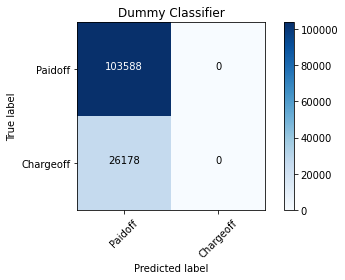

In [19]:
# Create class names
classes = ['Paidoff', 'Chargeoff']

plot_confusion_matrix(metrics.confusion_matrix(y_test, dummy_results['Test Results']['Predictions']), 
                      classes=classes, title=dummy_results['Model Description'])

In [20]:
df.chargeoff.describe()

count    432551.000000
mean          0.201856
std           0.401386
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: chargeoff, dtype: float64

The baseline classifier Accuracy score is 79.8% which represents 1 - mean `chargeoff` rate.  The dataset is moderately imbalanced with the `chargeoff` population at 20.2% .  These metrics show why it is important to choose the correct evaluation metric because we can achieve pretty good accuracy by simply predicting 0 for all loans.  We are capturing a variety of model evaluation metrics and then will compare at the end of each next sections.

### 4.3 Training Entire Dataset

The following classification models will be trained on the entire dataset and evaluated on the test set.

1. LogisticRegression
2. GaussianNB
3. RandomForestClassifier
4. AdaBoostClassifier
5. GradientBoostingClassifier
6. XGBClassifier
7. LGBMClassifier

#### 4.3.1 LogisticRegression

In [21]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(max_iter=1000, random_state=SEED)

log_results = evaluate_model('Logistic Regression', log, X_train, y_train)

log_results

{'Model Description': 'Logistic Regression',
 'Classifier': LogisticRegression(max_iter=1000, random_state=42),
 'Training Time': 10.287756204605103,
 'Train Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0.34, 0.03, 0.12, ..., 0.12, 0.05, 0.1 ]),
  'Accuracy Score': 0.8001221989200258,
  'Precision Score': 0.5378182265404009,
  'Recall Score': 0.07153022000490718,
  'F1 Score': 0.1262668553114082,
  'F2 Score': 0.08653545519667868,
  'Average Precision Score': 0.3901094662963812,
  'False Omission Rate': 0.19263950260305307},
 'Test Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0.28, 0.16, 0.16, ..., 0.25, 0.29, 0.24]),
  'Accuracy Score': 0.8012268236672164,
  'Precision Score': 0.5562060889929742,
  'Recall Score': 0.0725800290320116,
  'F1 Score': 0.128404406298574,
  'F2 Score': 0.08785883397454868,
  'Average Precision Score': 0.3939581879220544,
  'False Omission Rate': 0.192148793

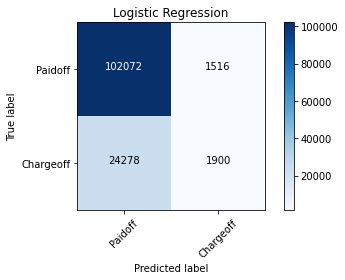

In [22]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, log_results['Test Results']['Predictions']), 
                      classes=classes, title=log_results['Model Description'])

The LogisticRegression model does not perform very well on the entire dataset.  Precision is 55.6% so when the model predicts the loan will chargeoff it is only correct about half of the time.  Recall is quite poor at 7.27% and Average Precision is .394. 

#### 4.3.2 GaussianNB

In [23]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb_results = evaluate_model('Gaussian Naive Bayes', gnb, X_train, y_train)

gnb_results

{'Model Description': 'Gaussian Naive Bayes',
 'Classifier': GaussianNB(),
 'Training Time': 0.40836071968078613,
 'Train Results': {'Predictions': array([0, 0, 0, ..., 1, 0, 0], dtype=int8),
  'Probabilities': array([3.25e-01, 2.70e-11, 2.01e-02, ..., 1.00e+00, 1.49e-10, 9.03e-02]),
  'Accuracy Score': 0.6915633205079512,
  'Precision Score': 0.3328427358754573,
  'Recall Score': 0.5252801177721436,
  'F1 Score': 0.40748401177545424,
  'F2 Score': 0.47083610686731897,
  'Average Precision Score': 0.32290268447108267,
  'False Omission Rate': 0.14067589576547232},
 'Test Results': {'Predictions': array([0, 0, 1, ..., 0, 0, 1], dtype=int8),
  'Probabilities': array([0.36, 0.04, 0.54, ..., 0.01, 0.04, 0.85]),
  'Accuracy Score': 0.6917913783271427,
  'Precision Score': 0.33214277036713075,
  'Recall Score': 0.5221942088776835,
  'F1 Score': 0.4060295537239177,
  'F2 Score': 0.4685711151786877,
  'Average Precision Score': 0.32192904902825015,
  'False Omission Rate': 0.14115947589973932}

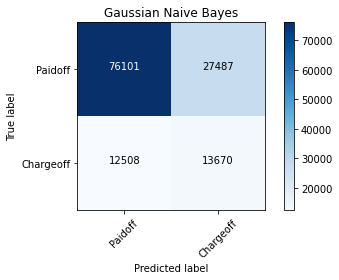

In [24]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, gnb_results['Test Results']['Predictions']), 
                      classes=classes, title=gnb_results['Model Description'])

The Gaussian Naive Bayes model handles the imbalanced dataset better as it predicted `chargeoff` for 41,114 loans vs. the 3,417 from the Logistic Regression model.  However, these predictions are quite poor as well with Precision at 33.22%.  Recall improved quite a bit though at 52.2% and Average Precision is .322.

#### 4.3.3 RandomForestClassifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Limit depth of tree otherwise it will expand all leaves and extremely overfit training data
rf = RandomForestClassifier(max_depth=10, random_state=SEED)

rf_results = evaluate_model('Random Forest Classifier', rf, X_train, y_train)

rf_results

{'Model Description': 'Random Forest Classifier',
 'Classifier': RandomForestClassifier(max_depth=10, random_state=42),
 'Training Time': 46.29463815689087,
 'Train Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0.24, 0.04, 0.16, ..., 0.15, 0.05, 0.11]),
  'Accuracy Score': 0.8000297240616279,
  'Precision Score': 0.7852283770651117,
  'Recall Score': 0.013216651672528012,
  'F1 Score': 0.02599575316903674,
  'F2 Score': 0.01645158794473244,
  'Average Precision Score': 0.443022911635809,
  'False Omission Rate': 0.1999198027545434},
 'Test Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0.28, 0.17, 0.11, ..., 0.17, 0.26, 0.34]),
  'Accuracy Score': 0.799161567745018,
  'Precision Score': 0.6666666666666666,
  'Recall Score': 0.008862403544961418,
  'F1 Score': 0.01749227173339365,
  'F2 Score': 0.011041309727774604,
  'Average Precision Score': 0.4010203070937906,
  'False Omission Rate': 

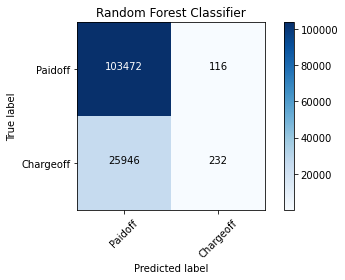

In [26]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, rf_results['Test Results']['Predictions']), 
                      classes=classes, title=rf_results['Model Description'])

The Random Forest Classifier performs similar to Logistic Regression with 54.41% Precision.  Recall improved a little to 9.35% and Average Precision is .3918.

#### 4.3.4 AdaBoostClassifier

In [27]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(random_state=SEED)

abc_results = evaluate_model('AdaBoost Classifer', abc, X_train, y_train)

abc_results

{'Model Description': 'AdaBoost Classifer',
 'Classifier': AdaBoostClassifier(random_state=42),
 'Training Time': 21.565549612045288,
 'Train Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0.5 , 0.48, 0.49, ..., 0.49, 0.49, 0.49]),
  'Accuracy Score': 0.8008421817461235,
  'Precision Score': 0.540136841090874,
  'Recall Score': 0.0916823423570786,
  'F1 Score': 0.15675690793153596,
  'F2 Score': 0.10993774444230867,
  'Average Precision Score': 0.39534532275763784,
  'False Omission Rate': 0.18990588492790894},
 'Test Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0.5 , 0.49, 0.49, ..., 0.49, 0.5 , 0.49]),
  'Accuracy Score': 0.8019280859393061,
  'Precision Score': 0.5527895087797289,
  'Recall Score': 0.0950034380013752,
  'F1 Score': 0.16214101770055742,
  'F2 Score': 0.11386215674245266,
  'Average Precision Score': 0.399458906019875,
  'False Omission Rate': 0.18912403106963527}}

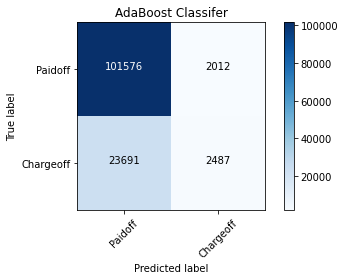

In [28]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, abc_results['Test Results']['Predictions']), 
                      classes=classes, title=abc_results['Model Description'])

AdaBoost Classifier performs quite similar to the Random Forest Classifier and has a ROC-AUC of .3993.

#### 4.3.5 GradientBoostingClassifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=SEED)

gb_results = evaluate_model('Gradient Boosting Classifier', gb, X_train, y_train)

gb_results

{'Model Description': 'Gradient Boosting Classifier',
 'Classifier': GradientBoostingClassifier(random_state=42),
 'Training Time': 92.13629293441772,
 'Train Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0.28, 0.03, 0.13, ..., 0.13, 0.06, 0.1 ]),
  'Accuracy Score': 0.8026850735670525,
  'Precision Score': 0.5796769389391683,
  'Recall Score': 0.08276764537498978,
  'F1 Score': 0.144852856979274,
  'F2 Score': 0.09989378881742336,
  'Average Precision Score': 0.4118766375145117,
  'False Omission Rate': 0.19069496966564192},
 'Test Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0.32, 0.22, 0.11, ..., 0.18, 0.31, 0.35]),
  'Accuracy Score': 0.8032227239800872,
  'Precision Score': 0.5864479698843775,
  'Recall Score': 0.08331423332569333,
  'F1 Score': 0.145900926514366,
  'F2 Score': 0.1005708699541644,
  'Average Precision Score': 0.4113048983823563,
  'False Omission Rate': 0.190381365

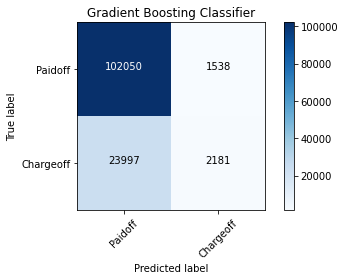

In [30]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, gb_results['Test Results']['Predictions']), 
                      classes=classes, title=gb_results['Model Description'])

The Gradient Boosting Classifier performs similar to Logistic Regression and Random Forest.  Precision is 58.7%, Recall is quite poor as well at 8.13% and Average Precision has improved a little to .4108.  Of all models so far Gradient Boosting also takes the longest to train the model.

#### 4.3.6 XGBClassifier

In [31]:
import xgboost as xgb

xgbc = xgb.XGBClassifier(eval_metric='aucpr', use_label_encoder=False, random_state=SEED)

xgbc_results = evaluate_model('XGB Classifer', xgbc, X_train, y_train)

xgbc_results

{'Model Description': 'XGB Classifer',
 'Classifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, subsample=1, tree_method='exact',
               use_label_encoder=False, validate_parameters=1, verbosity=None),
 'Training Time': 15.585451126098633,
 'Train Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0]),
  'Probabilities': array([0.36, 0.02, 0.12, ..., 0.14, 0.03, 0.17], dtype=float32),
  'Accuracy Score': 0.8134022491206632,
  'Precision Score': 0.6452017038336256,
  'Recall Score': 0.16847

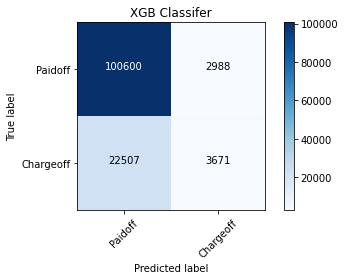

In [32]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, xgbc_results['Test Results']['Predictions']), 
                      classes=classes, title=xgbc_results['Model Description'])

XGB Classifier performs the best so far for Recall and Average Precision at 14.03% and .4149 respectively.

#### 4.3.7 LGBMClassifier

In [33]:
import lightgbm as lgb

lgbc = lgb.LGBMClassifier(random_state=SEED)

lgbm_results = evaluate_model('LGBM Classifer', lgbc, X_train, y_train)

lgbm_results

{'Model Description': 'LGBM Classifer',
 'Classifier': LGBMClassifier(random_state=42),
 'Training Time': 2.0688955783843994,
 'Train Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0.29, 0.02, 0.12, ..., 0.12, 0.06, 0.09]),
  'Accuracy Score': 0.8061330647158875,
  'Precision Score': 0.5975639073643721,
  'Recall Score': 0.12197595485401161,
  'F1 Score': 0.20259733202923358,
  'F2 Score': 0.1450670962068952,
  'Average Precision Score': 0.436974803580223,
  'False Omission Rate': 0.18490144881607684},
 'Test Results': {'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'Probabilities': array([0.37, 0.15, 0.12, ..., 0.24, 0.3 , 0.28]),
  'Accuracy Score': 0.8035695020267251,
  'Precision Score': 0.5652503793626708,
  'Recall Score': 0.11383604553441821,
  'F1 Score': 0.18950715421303657,
  'F2 Score': 0.1354742508001164,
  'Average Precision Score': 0.4181277695456392,
  'False Omission Rate': 0.1863382974279885}}

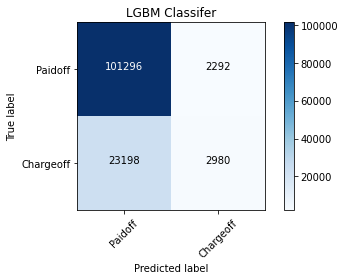

In [34]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, lgbm_results['Test Results']['Predictions']), 
                      classes=classes, title=lgbm_results['Model Description'])

LGBM Classifier improves upon the XGB Classifier with Average Precision of .4188 but Recall decreased to 11.47%.

In [35]:
models = [log_results, gnb_results, rf_results, abc_results, gb_results, xgbc_results, lgbm_results]

initial_models_df = pd.json_normalize(models)
initial_models_df[['Model Description', 'Training Time', 'Test Results.Accuracy Score', 
                                      'Test Results.Precision Score', 'Test Results.Recall Score', 
                                      'Test Results.F1 Score', 'Test Results.F2 Score', 
                                      'Test Results.False Omission Rate', 'Test Results.Average Precision Score']].sort_values(by='Test Results.Average Precision Score', ascending=False)

Finished loading model, total used 100 iterations


,Model Description,Training Time,Test Results.Accuracy Score,Test Results.Precision Score,Test Results.Recall Score,Test Results.F1 Score,Test Results.F2 Score,Test Results.False Omission Rate,Test Results.Average Precision Score
6,LGBM Classifer,2.068896,0.803570,0.565250,0.113836,0.189507,0.135474,0.186338,0.418128
5,XGB Classifer,15.585451,0.803531,0.551284,0.140232,0.223589,0.164810,0.182825,0.413556
4,Gradient Boosting Classifier,92.136293,0.803223,0.586448,0.083314,0.145901,0.100571,0.190381,0.411305
2,Random Forest Classifier,46.294638,0.799162,0.666667,0.008862,0.017492,0.011041,0.200482,0.401020
3,AdaBoost Classifer,21.565550,0.801928,0.552790,0.095003,0.162141,0.113862,0.189124,0.399459
0,Logistic Regression,10.287756,0.801227,0.556206,0.072580,0.128404,0.087859,0.192149,0.393958
1,Gaussian Naive Bayes,0.408361,0.691791,0.332143,0.522194,0.406030,0.468571,0.141159,0.321929


LGBM Classifier has the best model performance and the 2nd fastest training time.

### 4.4 Under Sampling

All models except for Gaussian Naive Bayes performed poorly on Recall.  Let's explore random under sampling to force an equal distribution by randomly removing paid off loans.

#### 4.4.1 Random Under Sampling

In [36]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False, random_state=SEED)

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(Counter(y_train_rus))

Counter({0: 61135, 1: 61135})


In [37]:
# Loop through models and rerun using the under sampled data
model_rus_results = []
for model in models:
    model_desc = model['Model Description'] + ' Under Sampled'
    print(model_desc)
    results = evaluate_model(model_desc, model['Classifier'], X_train_rus, y_train_rus)
    print('Test Average Precision Score:', "{:.6f}".format(results['Test Results']['Average Precision Score']))
    print('-----------------------------------')
    model_rus_results.append(results)

Logistic Regression Under Sampled
Test Average Precision Score: 0.392850
-----------------------------------
Gaussian Naive Bayes Under Sampled
Test Average Precision Score: 0.322912
-----------------------------------
Random Forest Classifier Under Sampled
Test Average Precision Score: 0.398485
-----------------------------------
AdaBoost Classifer Under Sampled
Test Average Precision Score: 0.395797
-----------------------------------
Gradient Boosting Classifier Under Sampled
Test Average Precision Score: 0.410577
-----------------------------------
XGB Classifer Under Sampled
Test Average Precision Score: 0.403010
-----------------------------------
LGBM Classifer Under Sampled
Test Average Precision Score: 0.415599
-----------------------------------


In [38]:
models_rus_df = pd.json_normalize(model_rus_results)
models_rus_df = models_rus_df[['Model Description', 'Training Time', 'Test Results.Accuracy Score', 
                                      'Test Results.Precision Score', 'Test Results.Recall Score', 
                                      'Test Results.F1 Score', 'Test Results.F2 Score', 
                                      'Test Results.False Omission Rate', 'Test Results.Average Precision Score']]
models_rus_df.sort_values(by='Test Results.Average Precision Score', ascending=False)

Finished loading model, total used 100 iterations


,Model Description,Training Time,Test Results.Accuracy Score,Test Results.Precision Score,Test Results.Recall Score,Test Results.F1 Score,Test Results.F2 Score,Test Results.False Omission Rate,Test Results.Average Precision Score
6,LGBM Classifer Under Sampled,1.005312,0.670900,0.344480,0.699251,0.461571,0.579823,0.102743,0.415599
4,Gradient Boosting Classifier Under Sampled,32.008096,0.662970,0.337853,0.698716,0.455470,0.575728,0.104288,0.410577
5,XGB Classifer Under Sampled,6.745530,0.667548,0.340414,0.691115,0.456149,0.573043,0.105535,0.403010
2,Random Forest Classifier Under Sampled,13.529953,0.655064,0.331447,0.697952,0.449455,0.571551,0.105934,0.398485
3,AdaBoost Classifer Under Sampled,8.833120,0.653006,0.329399,0.695164,0.446994,0.568837,0.107085,0.395797
0,Logistic Regression Under Sampled,2.785545,0.654023,0.330931,0.699786,0.449359,0.572226,0.105618,0.392850
1,Gaussian Naive Bayes Under Sampled,0.131449,0.621804,0.302237,0.668424,0.416257,0.538046,0.120772,0.322912


The LGBM Classifier performed the best for both the initial default model and using the random under-sampled data.  Comparing the default models to the random under-sampled data models really demonstrates the tradeoff between Precision and Recall in the Average Precision Score metric.  The Average Precision Score was quite similar in each run but with the random under-sampled data Recall improved at the cost of Precision.  Let's plot the Precision Recall Curves for both LGBM Classifier models to visualize that tradeoff.

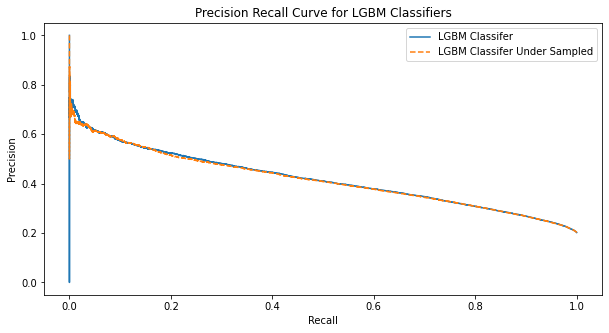

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
precision, recall, thresholds = metrics.precision_recall_curve(y_test, lgbm_results['Test Results']['Probabilities'])
ax.plot(recall, precision, label=lgbm_results['Model Description'])
precision_rus, recall_rus, thresholds_rus = metrics.precision_recall_curve(y_test, model_rus_results[6]['Test Results']['Probabilities'])
ax.plot(recall_rus, precision_rus, label=model_rus_results[6]['Model Description'], linestyle='--')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.legend()
plt.title('Precision Recall Curve for LGBM Classifiers')
plt.show()

The Precision Recall curves demonstrates that the LGBM Classifier using the under-sampled data is virtually the same model but the balanced class probabilities shifts more predictions to `chargeoff` and increases Recall.  Since the models trained on the under-sampled data achieved better Recall, we can accomplish a similar result using the entire dataset by either:

1) Adjusting the class_weight/scale_pos_weight parameters when training the model or<br>
2) Using a lower threshold for predictions

In the model optimization stage we will explore both of these options further.

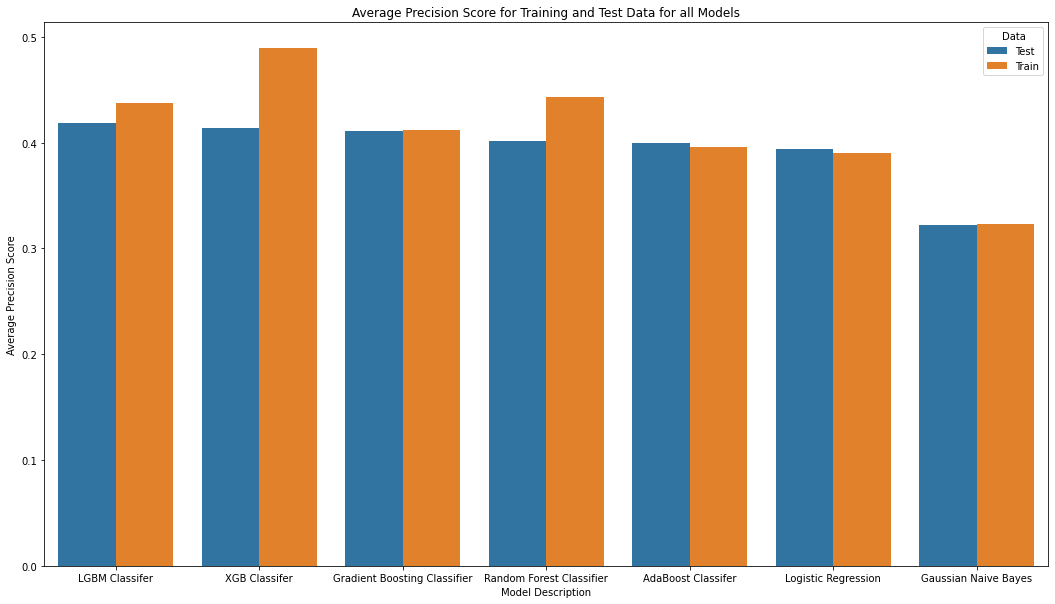

In [40]:
fig, ax = plt.subplots(figsize=(18,10))
avg_prec_test = initial_models_df[['Model Description', 'Test Results.Average Precision Score']].copy()
avg_prec_test.rename(columns = {'Test Results.Average Precision Score': 'Average Precision Score'}, inplace = True)
avg_prec_test['Data'] = 'Test'
avg_prec_test.sort_values(by='Average Precision Score', ascending=False, inplace=True)
avg_prec_train = initial_models_df[['Model Description', 'Train Results.Average Precision Score']].copy()
avg_prec_train.rename(columns = {'Train Results.Average Precision Score': 'Average Precision Score'}, inplace = True)
avg_prec_train['Data'] = 'Train'

avg_prec_df = pd.concat([avg_prec_test, avg_prec_train], axis=0)
sns.barplot(x="Model Description", y="Average Precision Score", hue='Data', data=avg_prec_df, ax=ax)
plt.title('Average Precision Score for Training and Test Data for all Models')
plt.show()

The LGBM Classifier has the highest Average Precision Score on the Test data and the XGB Classifier performed the best on the Train data.  In the next stage we will optimize both of these classifiers to see if the XGB Classifier can be tuned to outperform the LGBM classifier.

### 4.5 Model Optimization

For model optimization purposes we will focus on the F2 Score since this evaluation metric puts more weight on Recall.

In [41]:
# Make a custom scorer using f2_score
f2_scorer = metrics.make_scorer(metrics.fbeta_score, beta=2)

#### 4.5.1 Option 1: Optimize Class Weight

Let's start with the XGBClassifier by performing a GridSearch on the best `scale_pos_weight` and then Bayesian hyper-parameter optimization on all other numeric parameters.

##### 4.5.1.1 XGBClassifier

In [42]:
# GridSearch for scale_pos_weight
from sklearn.model_selection import GridSearchCV

weights = [1, 2, 5, 10, 20]
gs_params = dict(scale_pos_weight=weights)

xgbc = xgb.XGBClassifier(eval_metric='aucpr', use_label_encoder=False, random_state=SEED)

xgbc_gs = GridSearchCV(estimator=xgbc, param_grid=gs_params, 
                    cv=5, scoring=f2_scorer)

xgbc_gs.fit(X_train, y_train)

print('Best Score: {:.4f}'.format(xgbc_gs.best_score_))
print("Best Parameters: {}".format(xgbc_gs.best_params_))

Best Score: 0.6038
Best Parameters: {'scale_pos_weight': 10}


10 is the optimal `scale_pos_weight`.  Let's now perform hyper-parameter optimization for some of the other XGBClassifier parameters.

In [43]:
# Format input params for XGBClassifier
def xgbc_format_params(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_child_weight': int(params['min_child_weight']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': '{:.3f}'.format(params['subsample']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    return params

In [44]:
# Define objective function for XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

# Define loss objective function
def xgbc_objective(params):
    params = xgbc_format_params(params)
    
    clf = xgb.XGBClassifier(eval_metric='aucpr', use_label_encoder=False, scale_pos_weight=10, 
                            **params, random_state=SEED)
    
    f2score_mean = cross_val_score(clf, X_train, y_train, cv=5, scoring=f2_scorer).mean()

    return {'loss': -f2score_mean, 'status': STATUS_OK}

In [45]:
# Define optimization parameters for xgbc
xgbc_space = {
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'gamma': hp.uniform('gamma', 0.0, 10.0),
    'subsample': hp.uniform('subsample', 0.3, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)
}

In [46]:
# Set random state for hyperopt
rstate = np.random.RandomState(SEED)

trials = Trials()

xgbc_best = fmin(fn=xgbc_objective, space=xgbc_space, algo=tpe.suggest, max_evals=10, trials=trials, rstate=rstate)

100%|███████████████████████████████████████████████| 10/10 [27:46<00:00, 166.65s/trial, best loss: -0.605360134696282]


In [47]:
print("XGBClassifier Hyperopt estimated optimum {}".format(xgbc_best))

XGBClassifier Hyperopt estimated optimum {'colsample_bytree': 0.8603522620197213, 'gamma': 1.884252917654301, 'max_depth': 5.0, 'min_child_weight': 9.0, 'subsample': 0.8138196125898978}


In [48]:
# Fit final optimized model and run cross-validation
params = {
    'max_depth': int(xgbc_best['max_depth']),
    'min_child_weight': int(xgbc_best['min_child_weight']),
    'gamma': "{:.3f}".format(xgbc_best['gamma']),
    'subsample': '{:.3f}'.format(xgbc_best['subsample']),
    'colsample_bytree': '{:.3f}'.format(xgbc_best['colsample_bytree']),
    }
xgbc_opt = xgb.XGBClassifier(eval_metric='aucpr', use_label_encoder=False, scale_pos_weight=10,
                             **params, random_state=SEED)

xgbc_opt.fit(X_train, y_train)
model_metrics(xgbc_opt, X_test, y_test)

{'Predictions': array([1, 0, 1, ..., 1, 1, 1]),
 'Probabilities': array([0.85, 0.26, 0.6 , ..., 0.75, 0.83, 0.85], dtype=float32),
 'Accuracy Score': 0.44785228796448995,
 'Precision Score': 0.2568654290358457,
 'Recall Score': 0.9175643670257468,
 'F1 Score': 0.4013702063664467,
 'F2 Score': 0.6058802163209298,
 'Average Precision Score': 0.41591570652976667,
 'False Omission Rate': 0.05952446626579136}

#### 4.5.1.2 LGBMClassifier

In [49]:
# GridSearch for scale_pos_weight
lgbc = lgb.LGBMClassifier(random_state=SEED)

lgbc_gs = GridSearchCV(estimator=lgbc, param_grid=gs_params, 
                    cv=5, scoring=f2_scorer)

lgbc_gs.fit(X_train, y_train)

print('Best Score: {:.4f}'.format(lgbc_gs.best_score_))
print("Best Parameters: {}".format(lgbc_gs.best_params_))

Best Score: 0.6050
Best Parameters: {'scale_pos_weight': 10}


In [50]:
# Format input params for LGBMClassifier
def lgbc_format_params(params, scale_pos_weight):
    params = {
        'scale_pos_weight': scale_pos_weight,
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples']),
        'max_bin': int(params['max_bin']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'subsample': '{:.3f}'.format(params['subsample']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    return params

In [51]:
# Define loss objective function
def lgbc_objective(params):
    params = lgbc_format_params(params, scale_pos_weight=10)
    
    clf = lgb.LGBMClassifier(**params, random_state=SEED)
    
    f2score_mean = cross_val_score(clf, X_train, y_train, cv=5, scoring=f2_scorer).mean()

    return {'loss': -f2score_mean, 'status': STATUS_OK}

In [52]:
# Define optimization parameters for lgbc
lgbc_space = {
    'n_estimators': hp.quniform('max_depth', 100, 1000, 1),
    'num_leaves': hp.quniform('num_leaves', 1, 50, 1),
    'min_child_samples': hp.quniform('min_child_samples', 1, 100, 1),
    'max_bin': hp.quniform('max_bin', 1, 1000, 1),
    'learning_rate': hp.uniform('learning_rate', 0.0, 1.0),
    'subsample': hp.uniform('subsample', 0.3, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)
}

In [53]:
trials = Trials()

lgbc_best = fmin(fn=lgbc_objective, space=lgbc_space, algo=tpe.suggest, max_evals=10, trials=trials, rstate=rstate)

100%|███████████████████████████████████████████████| 10/10 [03:14<00:00, 19.45s/trial, best loss: -0.6060721166540501]


In [54]:
print("LGBMClassifier Hyperopt estimated optimum {}".format(lgbc_best))

LGBMClassifier Hyperopt estimated optimum {'colsample_bytree': 0.9639281051913686, 'learning_rate': 0.09749591346538378, 'max_bin': 262.0, 'max_depth': 544.0, 'min_child_samples': 25.0, 'num_leaves': 46.0, 'subsample': 0.7459238219968884}


In [55]:
# Fit final optimized model and run cross-validation
lgbc_params = lgbc_format_params(lgbc_best, scale_pos_weight=10)

lgbc_opt = lgb.LGBMClassifier(**lgbc_params, random_state=SEED)

lgbc_opt.fit(X_train, y_train)
model_metrics(lgbc_opt, X_test, y_test)

{'Predictions': array([1, 0, 1, ..., 1, 1, 1], dtype=int8),
 'Probabilities': array([0.85, 0.34, 0.55, ..., 0.72, 0.82, 0.83]),
 'Accuracy Score': 0.43983786199774977,
 'Precision Score': 0.2552669795634879,
 'Recall Score': 0.9266177706471083,
 'F1 Score': 0.4002673179103,
 'F2 Score': 0.6072204588010294,
 'Average Precision Score': 0.4175090018950938,
 'False Omission Rate': 0.0552964881980426}

#### 4.5.2 Option 2: Optimize Prediction Threshold

The LGBMClassifier model performed slightly better than the XGBClassifier with the optimized `scale_pos_weight`.  Let's now tune the LGBMClassifier with the default `scale_pos_weight` and identify the optimal prediction threshold that maximizes F2 Score.

In [56]:
# Define loss objective function for threshold optimization
def lgbc_objective2(params):
    params = lgbc_format_params(params, scale_pos_weight=1)
    
    clf = lgb.LGBMClassifier(**params, random_state=SEED)
    
    f2score_mean = cross_val_score(clf, X_train, y_train, cv=5, scoring=f2_scorer).mean()

    return {'loss': -f2score_mean, 'status': STATUS_OK}

In [57]:
trials = Trials()

lgbc_best2 = fmin(fn=lgbc_objective2, space=lgbc_space, algo=tpe.suggest, max_evals=10, trials=trials, rstate=rstate)

100%|███████████████████████████████████████████████| 10/10 [02:57<00:00, 17.72s/trial, best loss: -0.1887887580815629]


In [58]:
# Fit final optimized model and run cross-validation
lgbc_params2 = lgbc_format_params(lgbc_best2, scale_pos_weight=1)

lgbc_opt2 = lgb.LGBMClassifier(**lgbc_params2, random_state=SEED)

lgbc_opt2.fit(X_train, y_train)
model_metrics(lgbc_opt2, X_test, y_test)

{'Predictions': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'Probabilities': array([0.4 , 0.14, 0.11, ..., 0.25, 0.31, 0.26]),
 'Accuracy Score': 0.7982676510025739,
 'Precision Score': 0.5,
 'Recall Score': 0.15768966307586524,
 'F1 Score': 0.23976302491723295,
 'F2 Score': 0.18270660718079457,
 'Average Precision Score': 0.38889412587022426,
 'False Omission Rate': 0.1814665459632952}

Not surprisingly the F2 Score is significantly lower using the default `scale_pos_weight` but we will now evaluate at different prediction thresholds.

In [59]:
# Use threshold to get predictions
def preds_threshold(probs, threshold):
    return (probs >= threshold).astype('int')

In [60]:
# Fit model and create prediction probs
lgbc_opt2.fit(X_train, y_train)
y_pred_prob = lgbc_opt2.predict_proba(X_test)[:, 1]

# Create range of thresholds
thresholds = np.arange(0.01, 1.01, .01)

# Get F2 Scores
scores = [metrics.fbeta_score(y_test, preds_threshold(y_pred_prob, th), beta=2) for th in thresholds]

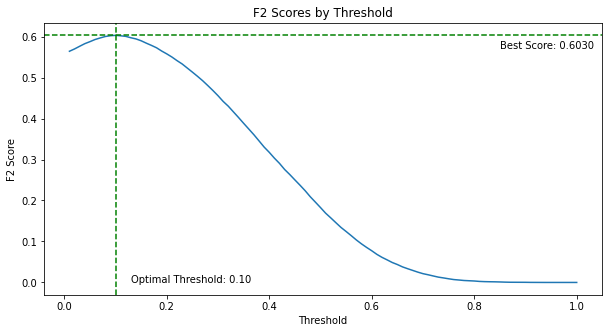

In [61]:
# Plot thresholds and scores
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(thresholds, scores)

score_i = np.argmax(scores)

best_score = scores[score_i]
th_opt = thresholds[score_i]

ax.axhline(y=best_score, color='g', linestyle='dashed')
ax.axvline(x=th_opt, color='g', linestyle='dashed')
plt.annotate('Best Score: {:.4f}'.format(best_score), xy=(0.85, .57))
plt.annotate('Optimal Threshold: {:.2f}'.format(th_opt), xy=(0.13, 0))

plt.ylabel('F2 Score')
plt.xlabel('Threshold')
plt.title('F2 Scores by Threshold')
plt.show()

### 4.6 Model Selection

7 different classification models were evaluated:

1. LogisticRegression
2. GaussianNB
3. RandomForestClassifier
4. AdaBoostClassifier
5. GradientBoostingClassifier
6. XGBClassifier
7. LGBMClassifier

The top 2 performing models (XGBClassifier and LGBMClassifier) were optimized for final model selection using a GridSearch and Automated Bayesian approach.

The LGBMClassifier model with `pos_scale_weight` = 10 performs the best with an F2 Score and Average Precision Score of **.607** and **.418** respectively on the test data.  The False Omission Rate has improved significantly from **20.16%** in the naive Dummy Classifier to **5.5%**.  The training time is significantly faster as observed in each tuning trial of **10.17** seconds per trial vs. **163.46** seconds per trial for the XGBClassifier model.

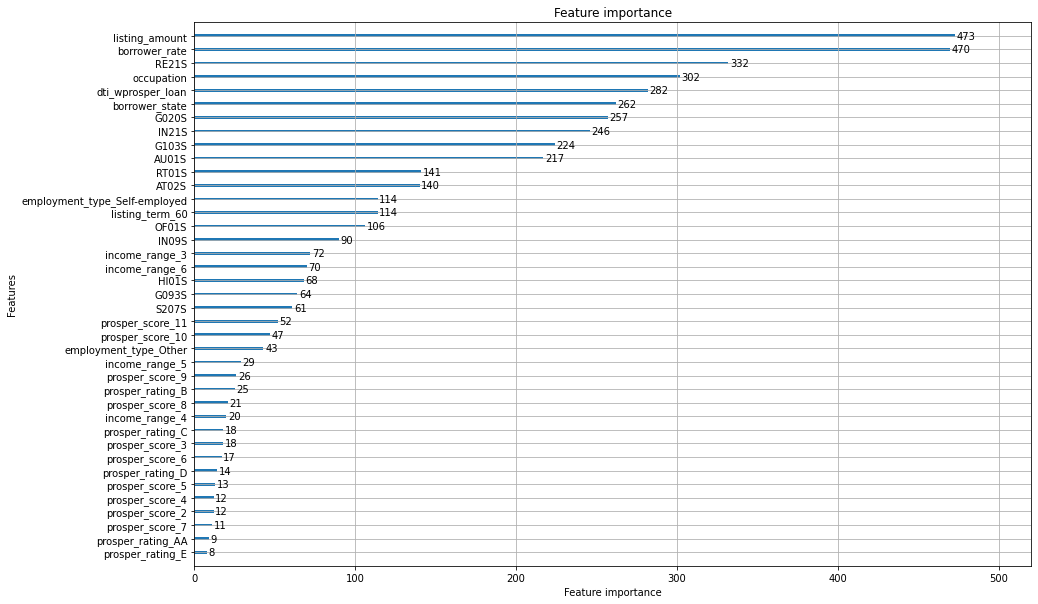

In [62]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(15,10))
lgb.plot_importance(lgbc_opt, ax=ax)
plt.show()

Final LGBMClassifier Classification Report:
              precision    recall  f1-score   support

     Paidoff       0.94      0.32      0.47    103588
   Chargeoff       0.26      0.93      0.40     26178

    accuracy                           0.44    129766
   macro avg       0.60      0.62      0.44    129766
weighted avg       0.81      0.44      0.46    129766



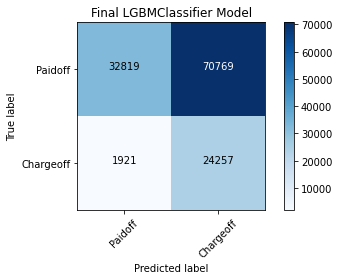

In [63]:
# Run classification report and plot confusion matrix
final_pred = lgbc_opt.predict(X_test)
final_prob = lgbc_opt.predict_proba(X_test)[:, 1]
print('Final LGBMClassifier Classification Report:')
print(metrics.classification_report(y_test, final_pred, target_names=classes))
plot_confusion_matrix(metrics.confusion_matrix(y_test, final_pred), 
                      classes=classes, title='Final LGBMClassifier Model')

As the confusion matrix shows the positive class scaling really forced the model to over predict `chargeoff` in order maximize performance.  In order to improve the model we need to obtain additional features with better predictive power.  We lost some features such as FICO score and many credit burearu fields simply because they were not populated for historical data when Prosper utilized Experian for credit scoring.

Once Prosper has more historical loans that have closed and Transunion credit scoring was used, we can revisit model training and introduce additional features.  However, this model was able to accomplish 93% Recall without sacrificing all of the True Negative loans.  From the test set there are still 32K loans to choose investments from so in the next section we will explore if the model performs better for investment recommendations.

# 5 Scenario Analysis<a id='5_scenario_analysis'></a> 

There are 3 different methods that we will compare for selecting investments:

1. Random
2. Rule Based Heuristic
3. Model Prediction and Loan Scorecard

The 1st option is simply just random selection.  When new listings become available we would just choose listings at random for investment.

The 2nd option is selecting investments based on logic to minimize loss exposure.  As identified in the EDA phase `prosper_rating` = AA listings have the lowest chargeoff %.  In this scenario we will randomly select listings that meet this criteria.

The 3rd option is utilizing the model to predict `chargeoff`. We will then score the listings based on 40% Interest Rate and 60% Prediction probability. 

Let's simulate those 3 scenarios and estimate a Simple Rate of Return for 40 loans.  Since each scenario will assume the investment amount is the same for each loan, a simple average of the Rate of Return is appropriate.

### 5.1 Random

In order to make sure the scenarios are comparable we will select 40 loans from the same time period in the test data.  It was observed in EDA that a loan with a 60 month term has a higher chargeoff % compared to 36 months.  However, It is preferred not to go back 5 years to select the potential investments.  Therefore, to simplify the comparison process we will select loans originated in the month of January 2018 with a term of 36 months.  The original core data file was obtained in January 2021 so this means all loans if held to maturity would have paid off prior to the data being acquired.

In [64]:
# Set paramaters
orig_month = 201801
listing_term = 36
num_loans = 40

df_investments = df_clean[(df_clean['origination_month'] == orig_month) & (df_clean['listing_term'] == listing_term)]
df_investments['origination_month_dt'] = pd.to_datetime(df_investments['origination_month'], format='%Y%m')
df_investments['closed_month_dt'] = pd.to_datetime(df_investments['closed_month'], format='%Y%m')
# Calculate number of months the investment was paid
df_investments['months'] = (df_investments['closed_month_dt'].dt.year - 
                           df_investments['origination_month_dt'].dt.year) * 12 + (df_investments['closed_month_dt'].dt.month 
                                                                                   - df_investments['origination_month_dt'].dt.month) + 1

# Calculate gain
df_investments['final_value'] = df_investments['principal_paid'] + df_investments['interest_paid'] + df_investments['debt_sale_recovery']

# Calculate rate of return
df_investments['ror'] = (df_investments['final_value'] / df_investments['listing_amount']) ** (1 / (df_investments['months']/12)) - 1


In [65]:
df_random = df_investments.sample(num_loans, random_state=SEED)

print('The average interest rate in the total loan pool is: ' + '{:.2%}'.format(df_random['borrower_rate'].mean()))
print('The average number of chargeoffs in the total loan pool is: ' + '{:.2%}'.format(df_random['chargeoff'].mean()))
print('The average rate of return is: ' + '{:.2%}'.format(df_random['ror'].mean()))

The average interest rate in the total loan pool is: 15.77%
The average number of chargeoffs in the total loan pool is: 20.00%
The average rate of return is: -1.69%


Randomly picking loans is not a great investment strategy.  20% of our investments would charge off and we would end up taking a loss of 1.69%

### 5.2 Rule Based

In [66]:
df_logic = df_investments[df_investments['prosper_rating'] == 'AA'].sample(num_loans, random_state=SEED)

print('The average interest rate in the total loan pool is: ' + '{:.2%}'.format(df_logic['borrower_rate'].mean()))
print('The average number of chargeoffs in the total loan pool is: ' + '{:.2%}'.format(df_logic['chargeoff'].mean()))
print('The average rate of return is: ' + '{:.2%}'.format(df_logic['ror'].mean()))

The average interest rate in the total loan pool is: 6.18%
The average number of chargeoffs in the total loan pool is: 5.00%
The average rate of return is: 1.71%


This is a very simple rule based investment decision using the `prosper_rating` but focusing solely on higher quality features will really decrease the average interest rates in the loan pool.  This scenario reduced the charge off % to 5% but with the lower yields the average rate of return only improvies to 1.71%.

### 5.3 Model Prediction and Listing Scorecard

In this scenario we will make predictions on the test data utilizing the optimized LGBMClassififer model and then score the loans weighted by interest rate and chargeoff probability.

In [67]:
# Create the scorecard
def listing_scorecard(df, weights):
    # Calculate weights and investment score
    df['borrower_rate_weight'] = df['borrower_rate_scaled'] * weights[0]
    df['chargeoff_probability_weight'] = (1 - df['chargeoff_probability']) * weights[1]
    df['investment_score'] = df['borrower_rate_weight'] + df['chargeoff_probability_weight']

    # Calculate investment rate of return
    df.sort_values(by='investment_score', ascending=False, inplace=True)
    
    return df

In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

weights = [.50, .50]

X_test_copy = X_test.copy()

X_test_copy['chargeoff_prediction'] = final_pred
X_test_copy['chargeoff_probability'] = final_prob

# Scale Interest Rate so it is on the same scale as the probabilities
df_investments['borrower_rate_scaled'] = scaler.fit_transform(df_investments[['borrower_rate']])

# Combine with original df_investments
df_scorecard = df_investments.merge(X_test_copy[['chargeoff_prediction', 'chargeoff_probability']], left_index=True, right_index=True)

# Create scorecard
df_scorecard = listing_scorecard(df_scorecard, weights)
# Select top 40 investments
df_investments_selected = df_scorecard[df_scorecard['chargeoff_prediction'] == 0].head(40)

print('The average interest rate in the total loan pool is: ' + '{:.2%}'.format(df_investments_selected['borrower_rate'].mean()))
print('The average number of chargeoffs in the investment pool is: ' + '{:.2%}'.format(df_investments_selected['chargeoff'].mean()))
print('The average rate of return is: ' + '{:.2%}'.format(df_investments_selected['ror'].mean()))

The average interest rate in the total loan pool is: 9.41%
The average number of chargeoffs in the investment pool is: 5.00%
The average rate of return is: 5.32%


This is the best result so far.  We were able to increase the rate of return to 5.32%.  The chargeoff % is the same as the rule based scenario at 5% but by identifying higher quality and higher yield loans we are almost able to accomplish our objective of 6.5%.  Let's simulate different weight % in the Scorecard.

In [69]:
# Create weight combinations
weights = [(np.round(v,1), np.round(1-v,1)) for v in np.arange(0.1, 1, .1)]
results = []
for w in weights:
    df_scorecard = listing_scorecard(df_scorecard, w)
    # Select top 40 investments
    df_investments_selected = df_scorecard[df_scorecard['chargeoff_prediction'] == 0].head(40)
    results.append({w: df_investments_selected['ror'].mean()})
    
results

[{(0.1, 0.9): 0.029938726944107756},
 {(0.2, 0.8): 0.03334486294841595},
 {(0.3, 0.7): 0.038060877771717024},
 {(0.4, 0.6): 0.05002150272504311},
 {(0.5, 0.5): 0.05319639380697063},
 {(0.6, 0.4): 0.0724596339339744},
 {(0.7, 0.3): 0.04282043673609193},
 {(0.8, 0.2): 0.03670937339636845},
 {(0.9, 0.1): 0.037427474350235766}]

The optimal weights is 60% Interest Rate and 40% Chargeoff Probability.

In [70]:
weights = [.60, .40]
# Create scorecard
df_scorecard = listing_scorecard(df_scorecard, weights)
# Select top 40 investments
df_investments_selected = df_scorecard[df_scorecard['chargeoff_prediction'] == 0].head(40)

print('The average interest rate in the total loan pool is: ' + '{:.2%}'.format(df_investments_selected['borrower_rate'].mean()))
print('The average number of chargeoffs in the investment pool is: ' + '{:.2%}'.format(df_investments_selected['chargeoff'].mean()))
print('The average rate of return is: ' + '{:.2%}'.format(df_investments_selected['ror'].mean()))

The average interest rate in the total loan pool is: 12.60%
The average number of chargeoffs in the investment pool is: 5.00%
The average rate of return is: 7.25%


Although performance based on model evaluation metrics is not very good we were still able to solve the problem by combining model predictions with a scoring system to minimize default risk exposure and maximize rate of return.  In the optimal scenario we were able to achieve 7.25% rate of return based on actual historical loan performance for a specific period of time.  Actual portfolio performance will vary but in the next stage we will finalize the model pipeline and create a live production investment selection system based on Prosper's loan listing API.